In [ ]:
pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl


temperature = ctrl.Antecedent(np.arange(0, 51, 1), 'temperature')
fan_speed = ctrl.Consequent(np.arange(0, 101, 1), 'fan_speed')


temperature['low'] = fuzz.trimf(temperature.universe, [0, 0, 25])
temperature['medium'] = fuzz.trimf(temperature.universe, [20, 25, 35])
temperature['high'] = fuzz.trimf(temperature.universe, [30, 50, 50])


fan_speed['low'] = fuzz.trimf(fan_speed.universe, [0, 0, 50])
fan_speed['medium'] = fuzz.trimf(fan_speed.universe, [30, 50, 70])
fan_speed['high'] = fuzz.trimf(fan_speed.universe, [60, 100, 100])


rule1 = ctrl.Rule(temperature['low'], fan_speed['low'])
rule2 = ctrl.Rule(temperature['medium'], fan_speed['medium'])
rule3 = ctrl.Rule(temperature['high'], fan_speed['high'])

fan_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
fan_simulation = ctrl.ControlSystemSimulation(fan_ctrl)


def calculate_fan_speed(temp):
    fan_simulation.input['temperature'] = temp
    fan_simulation.compute()
    return fan_simulation.output['fan_speed']

test_temperature = 30
calculated_speed = calculate_fan_speed(test_temperature)
print(f"Temperature: {test_temperature}°C, Fan Speed: {calculated_speed:.2f}%")


Temperature: 30°C, Fan Speed: 50.00%


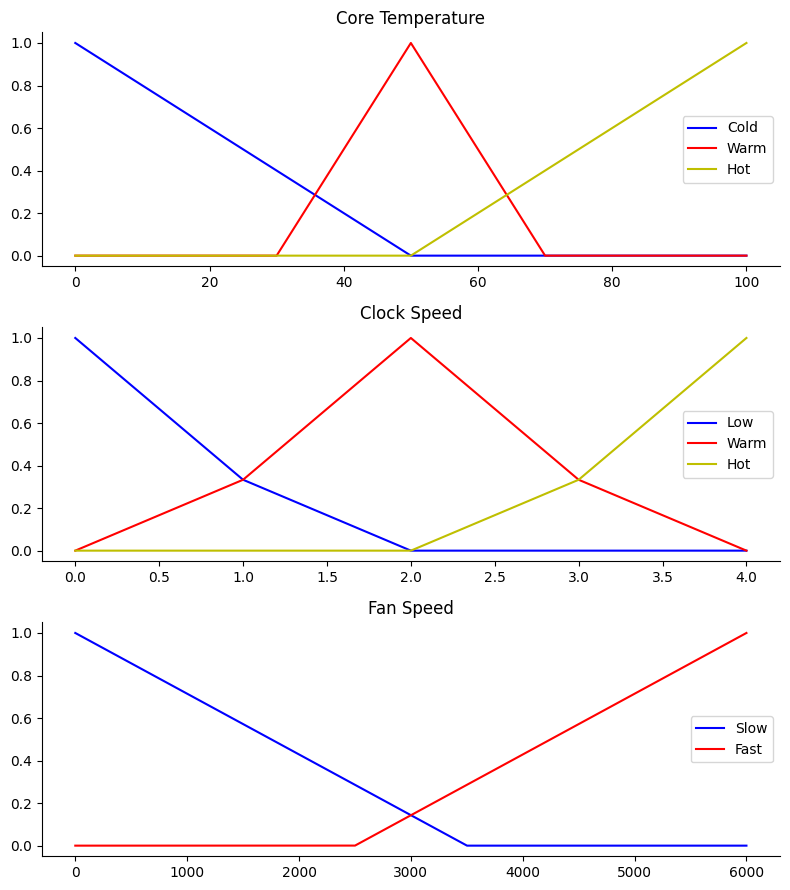

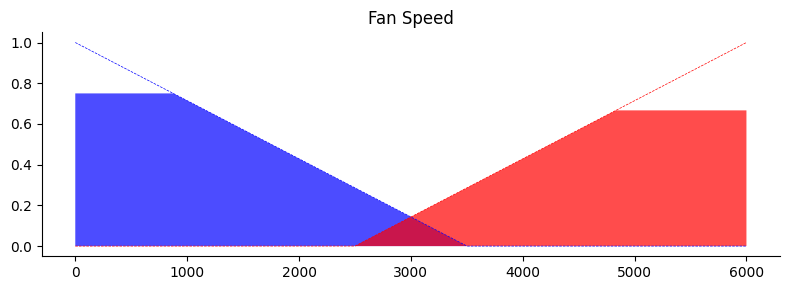

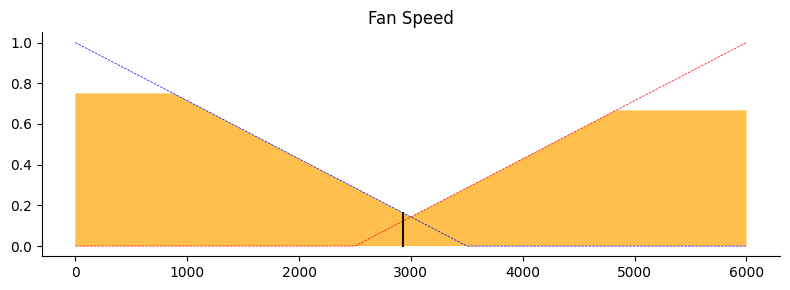

In [ ]:

import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt


graph_core_temp = np.arange(0, 101, 1)
ct_cold = fuzz.trimf(graph_core_temp, [0, 0, 50])
ct_warm = fuzz.trimf(graph_core_temp, [30, 50, 70])
ct_hot = fuzz.trimf(graph_core_temp, [50, 100, 100])

graph_clock_speed = np.arange(0, 5, 1)
cs_low = fuzz.trimf(graph_clock_speed, [0, 0, 1.5])
cs_warm = fuzz.trimf(graph_clock_speed, [0.5, 2, 3.5])
cs_hot = fuzz.trimf(graph_clock_speed, [2.5, 4, 4])

graph_fan_speed  = np.arange(0, 6001, 1)
fs_slow = fuzz.trimf(graph_fan_speed, [0, 0, 3500])
fs_fast = fuzz.trimf(graph_fan_speed, [2500, 6000, 6000])


fig, (graph0, graph1, graph2) = plt.subplots(nrows=3, figsize=(8, 9))

graph0.plot(graph_core_temp, ct_cold, 'b', linewidth=1.5, label='Cold')
graph0.plot(graph_core_temp, ct_warm, 'r', linewidth=1.5, label='Warm')
graph0.plot(graph_core_temp, ct_hot, 'y', linewidth=1.5, label='Hot')
graph0.set_title('Core Temperature')
graph0.legend()

graph1.plot(graph_clock_speed, cs_low, 'b', linewidth=1.5, label='Low')
graph1.plot(graph_clock_speed, cs_warm, 'r', linewidth=1.5, label='Warm')
graph1.plot(graph_clock_speed, cs_hot, 'y', linewidth=1.5, label='Hot')
graph1.set_title('Clock Speed')
graph1.legend()

graph2.plot(graph_fan_speed, fs_slow, 'b', linewidth=1.5, label='Slow')
graph2.plot(graph_fan_speed, fs_fast, 'r', linewidth=1.5, label='Fast')
graph2.set_title('Fan Speed')
graph2.legend()

for ax in (graph0, graph1, graph2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()


core_temp = 55
clock_speed = 3.5

cold_temp = fuzz.interp_membership(graph_core_temp, ct_cold, core_temp)
warm_temp = fuzz.interp_membership(graph_core_temp, ct_warm, core_temp)
hot_temp = fuzz.interp_membership(graph_core_temp, ct_hot, core_temp)

low_speed = fuzz.interp_membership(graph_clock_speed, cs_low, clock_speed)
warm_speed = fuzz.interp_membership(graph_clock_speed, cs_warm, clock_speed)
hot_speed = fuzz.interp_membership(graph_clock_speed, cs_hot, clock_speed)


active_rule1 = np.fmax(cold_temp, low_speed)
fan_speed_slow = np.fmin(active_rule1, fs_slow)

active_rule2 = np.fmax(warm_temp, warm_speed)
fan_speed_slow = np.fmin(active_rule2, fs_slow)

active_rule3 = np.fmax(hot_temp, hot_speed)
fan_speed_fast = np.fmin(active_rule3, fs_fast)

speed_zero = np.zeros_like(graph_fan_speed)


fig, graph = plt.subplots(figsize=(8, 3))

graph.fill_between(graph_fan_speed, speed_zero, fan_speed_slow, facecolor='b', alpha=0.7)
graph.plot(graph_fan_speed, fs_slow, 'b', linewidth=0.5, linestyle='--', )
graph.fill_between(graph_fan_speed, speed_zero, fan_speed_fast, facecolor='r', alpha=0.7)
graph.plot(graph_fan_speed, fs_fast, 'r', linewidth=0.5, linestyle='--')
graph.set_title('Fan Speed')

for ax in (graph,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()


aggregated = np.fmax(fan_speed_slow, fan_speed_fast)


fan_speed = fuzz.defuzz(graph_fan_speed, aggregated, 'centroid')
fan_speed_activation = fuzz.interp_membership(graph_fan_speed, aggregated, fan_speed)

fig, graph = plt.subplots(figsize=(8, 3))

graph.plot(graph_fan_speed, fs_slow, 'b', linewidth=0.5, linestyle='--', )
graph.plot(graph_fan_speed, fs_fast, 'r', linewidth=0.5, linestyle='--')
graph.fill_between(graph_fan_speed, speed_zero, aggregated, facecolor='Orange', alpha=0.7)
graph.plot([fan_speed, fan_speed], [0, fan_speed_activation], 'k', linewidth=1.5, alpha=0.9)
graph.set_title('Fan Speed')

for ax in (graph,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

plt.show()
